In [64]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from math import ceil

In [65]:
class ClacSelfSimilarities(object):
    def __init__(self, region_size, patch_size, bin_size):
        self.region_size = region_size
        self.patch_size = patch_size
        self.bin_size = bin_size
        self.theta, self.rho = self.cart2polar()
        self.bin = self.get_bin()
        self.alpha = 1/(85 ^ 2)

    def cart2polar(self):
        x, y = np.meshgrid(
            np.arange(self.region_size[1]), np.arange(self.region_size[0]))
        center_r = np.ceil(self.region_size/2).astype(int)
        theta = np.arctan2(x-center_r[1], y-center_r[0])
        rho = np.hypot(x-center_r[1], y-center_r[0])
        theta = theta*180/np.pi+180
        rho = np.log(rho)
        return theta, rho

    def get_bin(self):
        max_rho = np.max(self.rho)
        bin = {}
        m, n = np.arange(self.bin_size[0]), np.arange(self.bin_size[1])
        theta_low = m*24
        theta_up = (m+1)*24
        rho_low = max_rho*n/3
        rho_up = max_rho*(n+1)/3
        for i in range(self.bin_size[0]):
            for j in range(self.bin_size[1]):
                points = np.where((self.theta >= theta_low[i]) & (self.theta <= theta_up[i]) & (
                    self.rho >= rho_low[j]) & (self.rho <= rho_up[j]))
                bin[i, j] = points
        return bin

    def cal_ssd(self, patch, region, center_p):
        region_size = region.shape
        ssd = np.zeros((region_size[0], region_size[1]))
        for row in range(1+center_p[0], region_size[0]-center_p[0]):
            for col in range(1+center_p[1], region_size[1]-center_p[1]):
                ssd[row, col] = np.sum(
                    (patch-region[row-center_p[0]:row+center_p[0], col-center_p[1]:col+center_p[1], :])**2)
                ssd[row, col] = np.exp(-self.alpha*ssd[row, col])
        return ssd

    def get_self_sim_vec(self, region):
        self_similarities = np.zeros(self.bin_size[0]*self.bin_size[1])
        for i in range(self.bin_size[0]):
            for j in range(self.bin_size[1]):
                if len(region[self.bin[i, j]]) > 0:
                    self_similarities[i*self.bin_size[1] +
                                      j] = np.max(region[self.bin[i, j]])
                else:
                    self_similarities[i*self.bin_size[1]+j] = 0
        return self_similarities

    def cal_self_similarities(self, img):
        lab_image = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        img_size = lab_image.shape
        vec_size = self.bin_size[0]*self.bin_size[1]
        self_similarities = np.zeros((img_size[0], img_size[1], vec_size))
        center_r = np.floor(self.region_size/2).astype(int)
        center_p = np.floor(self.patch_size/2).astype(int)

        for row in range(center_r[0]+1, img_size[0]-center_r[0]):
            for col in range(center_r[1]+1, img_size[1]-center_r[1]):
                patch = lab_image[row-center_p[0]:row +
                                  center_p[0], col-center_p[1]:col+center_p[1], :]
                region = lab_image[row-center_r[0]:row +
                                   center_r[0]+1, col-center_r[1]:col+center_r[1]+1, :]
                ssd_region = self.cal_ssd(patch, region, center_p)
                vec = self.get_self_sim_vec(ssd_region)
                self_similarities[row, col, :] = (
                    vec-np.min(vec))/(np.max(vec)-np.min(vec))
        return self_similarities


def draw_result(src, sig_score, region_size, scale):
    ma = np.max(sig_score)
    mi = np.min(sig_score)

    norm_score = (sig_score-mi)/(ma-mi)
    norm_score = norm_score*255
    norm_score = cv2.resize(norm_score, (0, 0), fx=scale, fy=scale)
    plt.imshow(norm_score.astype(np.uint8))
    plt.show()

    x, y = np.where(sig_score == ma)
    rect_img = np.zeros(sig_score.shape)
    print(rect_img.shape)
    rect_img[(x-np.floor(region_size[0]/2).astype(int))[0]:(x+np.floor(region_size[0]/2).astype(int))[0],
             (y-np.floor(region_size[1]/2).astype(int))[0]:(y+np.floor(region_size[1]/2).astype(int))[0]] = 128
    rect_img = cv2.resize(rect_img, (0, 0), fx=scale, fy=scale)
    print(rect_img.shape)
    rect_size = src.shape
    src[:, :, 1] = src[:, :, 1] + \
        rect_img[:rect_size[0], :rect_size[1]].astype(np.uint8)

    plt.imshow(src[:, :, ::-1])
    plt.show()

In [66]:
region_size = np.array([45, 37])
patch_size = np.array([5, 5])
bin_size = np.array([15, 3])

num_imgs = 5
self_similarities = {}
sim = ClacSelfSimilarities(region_size, patch_size, bin_size)
for i in range(num_imgs):
    img = cv2.imread('images/{}.jpg'.format(i+1))
    img = cv2.resize(img, (ceil(img.shape[1]/3), ceil(img.shape[0]/3)))
    self_similarities[i] = sim.cal_self_similarities(img)

/tmp/ipykernel_646/3810874588.py:18: RuntimeWarning: divide by zero encountered in log
  rho = np.log(rho)


(81, 107, 3)


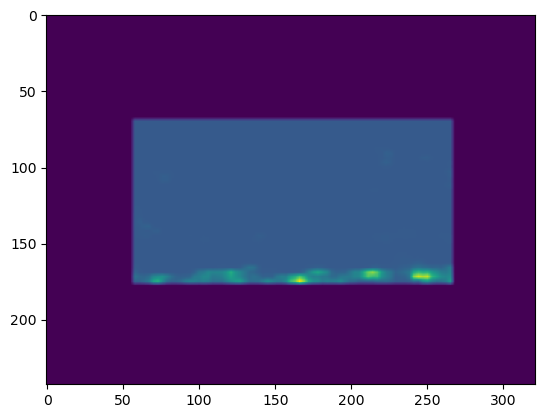

(81, 107)
(243, 321)


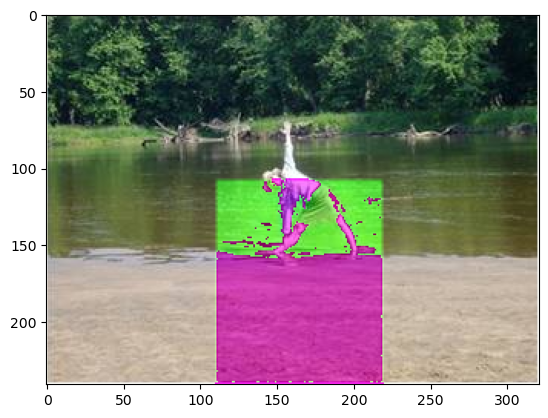

(75, 99, 3)


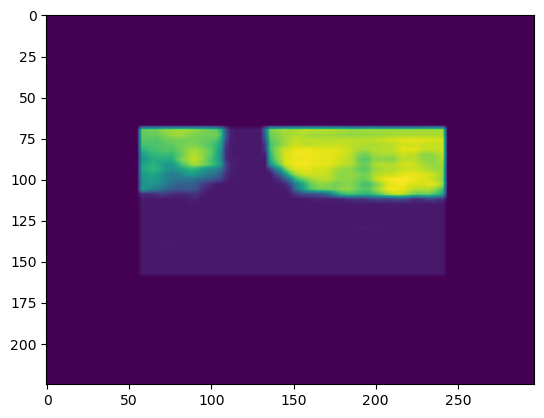

(75, 99)
(225, 297)


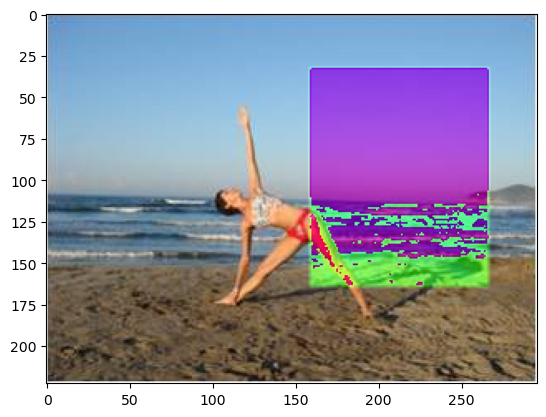

(68, 92, 3)


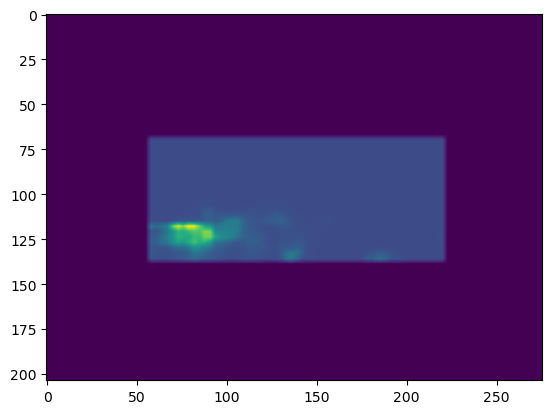

(68, 92)
(204, 276)


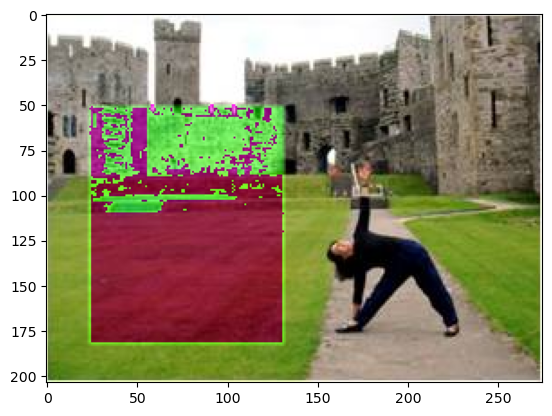

(102, 102, 3)


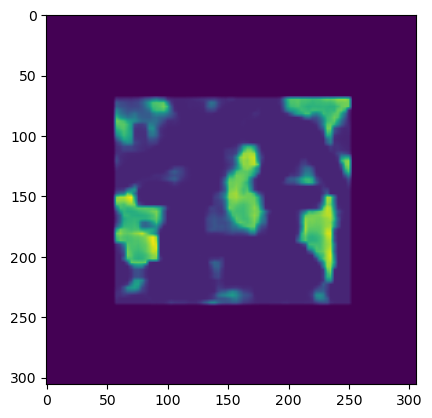

(102, 102)
(306, 306)


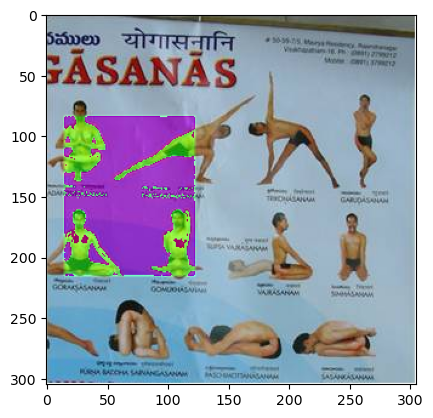

(84, 96, 3)


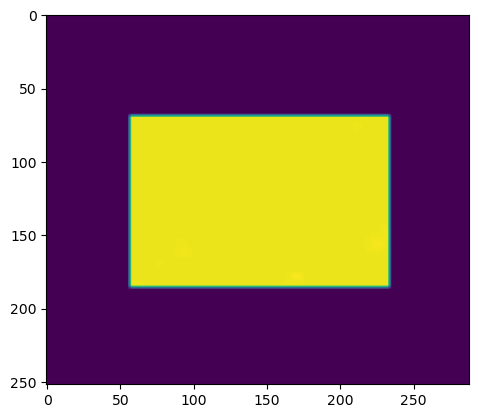

(84, 96)
(252, 288)


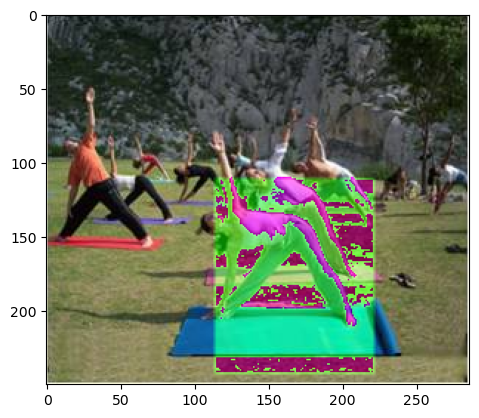

In [67]:

for i in range(num_imgs):
    src = cv2.imread('images/{}.jpg'.format(i+1))
    src = cv2.resize(src, (ceil(src.shape[1]/3), ceil(src.shape[0]/3)))
    print(src.shape)
    sig_score_img = np.zeros((src.shape[0], src.shape[1]))
    for row in range(src.shape[0]):
        for col in range(src.shape[1]):
            sub1 = self_similarities[i][row, col, :]
            max_match = np.zeros(num_imgs-1)
            nimag = 0
            match_score = {0: [], 1: [], 2: [], 3: [], 4: []}
            for n in range(num_imgs):
                if n != i:
                    temp = -1*(np.sum((self_similarities[n]-sub1)**2, axis=2))
                    max_match[nimag] = np.max(temp)
                    match_score[nimag] = list(temp.reshape(-1))
                    nimag = nimag+1

            temp2 = np.array(match_score[0]+match_score[1] +
                             match_score[2]+match_score[3]+match_score[4])
            avgmatch = np.mean(temp2)
            stdmatch = np.std(temp2)
            sig_score_img[row, col] = np.sum((max_match-avgmatch)/stdmatch)

    src = cv2.imread('images/{}.jpg'.format(i+1))
    draw_result(src, sig_score_img/4, region_size, 3)